### 1. Data loading, preprocessing, merging


In [3]:
import pandas as pd
app_df = pd.read_csv('data/application_record.csv')
cred_df = pd.read_csv('data/credit_record.csv')

cred_df.head(10)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


- `app_df`: application_record.csv loaded.
- `pd.read_csv()` reads the file contents and creates a tabular object called a DataFrame.
- `credit_df`: reads the credit_record.csv file and also creates a DataFrame.

`credit_record.csv` contains the ID-level records used to label each ID (client) as a **"good client"** or **"bad client"**. However, in its current form it is not suitable for merging with `app_df` because `credit_df` contains month-level data, so each ID appears in multiple rows with its monthly credit status.

Therefore we need to build a new aggregated DataFrame from `credit_df` that stores each ID in a single row and includes an `is_bad` column that classifies the clients. We then merge that aggregated DataFrame with `app_df`.

In this example we assume a strict bank: any client with at least 1 debt paid 60+ days late or at least 3 debts paid 30+ days late is labeled as `bad client`.


In [ ]:
def is_client_bad(series):
    late_statuses = ['1', '2', '3', '4', '5']
    very_late_statuses = ['2', '3', '4', '5']

    ever_very_late = any(s in very_late_statuses for s in series)

    freq_late_count = sum(s in late_statuses for s in series)
    is_frequent_offender = freq_late_count >= 3

    return 1 if (ever_very_late or is_frequent_offender) else 0

agg_df = cred_df.groupby('ID').agg(
    is_bad=('STATUS', is_client_bad)
).reset_index()

agg_df.head(10)

- `is_client_bad`: the function that decides whether the `is_bad` value for a given client is 1 (bad) or 0 (good)
- `late_statuses`: the late categories that count toward the max of 3 late payments
- `very_late_statuses`: the late categories where a single occurrence is enough for a "bad client" label
- `return 1 if (ever_very_late or is_frequent_offender) else 0`: if either condition is true, then `is_bad = 1` (bad client)
- `.reset_index()`: `groupby` sets ID as the index; `reset_index()` moves it back to a regular column, which makes merging easier


In [ ]:
df = pd.merge(app_df, agg_df, on='ID', how='inner')
df.head(10)

- `df = pd.merge()`: merges the two DataFrames provided as parameters (`app_df`, `agg_df`)
- `on='ID'`: specifies which column to join on (similar to SQL JOIN)
- `how='inner'`: keeps only rows that exist in both DataFrames. This is necessary because `app_df` has 438,557 rows, but only 36,457 clients have credit status records. For model training we can only use records that have credit status.
- `df.head(10)`: shows the first 10 rows of the merged DataFrame.


In [ ]:
print("Bad clients: ", df['is_bad'].value_counts())

---

## **2. Exploratory Data Analysis (EDA)**

Before we build models, we need to understand the data. This process is called Exploratory Data Analysis (EDA). Its goal is to better understand our data, discover patterns, and identify potential problems (e.g., missing values, incorrect entries).


In [7]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  str    
 2   FLAG_OWN_CAR         36457 non-null  str    
 3   FLAG_OWN_REALTY      36457 non-null  str    
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  str    
 7   NAME_EDUCATION_TYPE  36457 non-null  str    
 8   NAME_FAMILY_STATUS   36457 non-null  str    
 9   NAME_HOUSING_TYPE    36457 non-null  str    
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null  int64  
 1

`df.info()`: provides a basic summary of the DataFrame. We can see how many columns are there, how many non-missing values each column has, and the data types.

We can see that `OCCUPATION_TYPE` has far fewer entries (only 25,134 rows) compared to the 36,457 rows in other columns. This must be handled during data cleaning and preprocessing.


In [1]:
df.describe()

NameError: name 'df' is not defined

The `describe()` method provides statistical summaries for the numeric columns. It gives a quick overview of the distributions and helps identify anomalies. The output table includes:
- `count`: number of non-missing values
- `mean`: average
- `std`: standard deviation
- `min`: minimum value
- `max`: maximum value
- `25%, 50%, 75%`: quartiles (25th, 50th, 75th percentiles)

For example, `DAYS_BIRTH` and `DAYS_EMPLOYED` contain large negative numbers. This is due to the dataset's storage logic. According to the data dictionary, `DAYS_BIRTH` is the number of days before today (today = 0, yesterday = -1). `DAYS_EMPLOYED` is also counted backwards from today; if it is positive, it means the client is currently unemployed. This is problematic for modeling and needs to be addressed, similar to `OCCUPATION_TYPE`.


In [ ]:
print("Gender: ", df['CODE_GENDER'].value_counts(), '\n')
print("Occupation: ", df['OCCUPATION_TYPE'].value_counts(), '\n')
print("Owns a car: ", df['FLAG_OWN_CAR'].value_counts(), '\n')
print("Owns a property: ", df['FLAG_OWN_REALTY'].value_counts(), '\n')
print("Children count: ", df['CNT_CHILDREN'].value_counts(), '\n')
print("Income type: ", df['NAME_INCOME_TYPE'].value_counts(), '\n')
print("Education type: ", df['NAME_EDUCATION_TYPE'].value_counts(), '\n')
print("Family status: ", df['NAME_FAMILY_STATUS'].value_counts(), '\n')
print("Housing type: ", df['NAME_HOUSING_TYPE'].value_counts(), '\n')
print("Has a mobile: ", df['FLAG_MOBIL'].value_counts(), '\n')
print("Has a work phone: ", df['FLAG_WORK_PHONE'].value_counts(), '\n')
print("Has a phone: ", df['FLAG_PHONE'].value_counts(), '\n')
print("Has email: ", df['FLAG_EMAIL'].value_counts(), '\n')
print("Family size: ", df['CNT_FAM_MEMBERS'].value_counts(), '\n')

---

## **3. Data Cleaning and Preprocessing**

During EDA we identified anomalies that need to be handled before model training to ensure accurate predictions. Identified issues:
- Handling negative values and positive flag values in `DAYS_EMPLOYED`
- Handling large negative values in `DAYS_BIRTH`
- Handling many NULL values in `OCCUPATION_TYPE`
- `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY` are binary (M/F and Y/N), but models usually require numeric values, so we convert them to 1/0

### **3.1 Handling identified anomalies**

1. **Handling `DAYS_EMPLOYED` anomalies:**
- negative values -> number of days employed
- unemployed clients -> value 365243 -> model may think they have 1000 years of experience -> distorts the model
- Solution:
    - creating an `is_unemployed` column with 0/1 values,
    - converting negative values to years to avoid very large magnitudes (e.g., `days_employed` of -15713 vs. child count max 19; scale differences can distort model weights)

2. **Handling `DAYS_BIRTH`:**
A similar scale issue exists here, so we convert birth data to years to avoid distortion.

First we check that `DAYS_EMPLOYED` does not contain positive values other than the 365243 flag:


In [ ]:
strange_positives = df[(df['DAYS_EMPLOYED'] > 0) & (df['DAYS_EMPLOYED'] != 365243)]

print(f"Number of anomalies: {len(strange_positives)}")
if not strange_positives.empty:
    print(strange_positives['DAYS_EMPLOYED'].unique())

In [11]:
#1. Handle the DAYS_EMPLOYED anomaly
df['is_unemployed'] = (df['DAYS_EMPLOYED'] > 0).astype(int)
df['years_employed'] = ((df['DAYS_EMPLOYED'].clip(upper=0) * -1) / 365).round(1)

#2. Handle DAYS_BIRTH
df['age'] = (df['DAYS_BIRTH'] / -365).astype(int)
df = df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'])

print(df['is_unemployed'].value_counts())
print(df['years_employed'].value_counts())

is_unemployed
0    30322
1     6135
Name: count, dtype: int64
years_employed
0.0     6138
0.8      418
1.8      403
0.3      392
4.6      382
        ... 
24.5       1
43.0       1
36.9       1
0.1        1
30.9       1
Name: count, Length: 350, dtype: int64


- `df['is_unemployed'] = (df['DAYS_EMPLOYED'] > 0).astype(int)`: applies a logical check; positive values become True, others False. Converting to int results 1 or 0.
- `df['years_employed']`: we multiply days by -1 and divide by 365 to get years, rounded to one decimal.
- `.clip(upper=0)`: sets any value above 0 to 0. Since unemployed clients are marked with 365243, `upper=0` turns those into 0 and handles them properly.
- `df['age'] = (df['DAYS_BIRTH'] / -365).astype(int)`: converts `DAYS_BIRTH` to years in a new `age` column.
- `df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'])`: after transformation we drop the original columns.


In [ ]:
import seaborn as sns
sns.histplot(data=df, x='age', discrete=True)

3. **Handling `OCCUPATION_TYPE`:**
During EDA we saw that `OCCUPATION_TYPE` has more than 10,000 fewer rows than other columns. This is likely because it was optional and many clients did not provide it. In categorical cases like this, deleting those rows would remove about one third of the data. A better approach is to create a new "Unknown" category and assign all missing values to it. This lets the model learn whether missing occupation correlates with "bad client" outcomes.


In [ ]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')

print("Occupation types: ", df['OCCUPATION_TYPE'].value_counts())

4. **Handling binary text values:**
`FLAG_OWN_CAR` and `FLAG_OWN_REALTY` are binary (Y/N), but models typically use numeric data, so we convert them to 1/0. We also convert `CODE_GENDER` from M/F to 1/2.


In [14]:
df['CODE_GENDER'] = df['CODE_GENDER'].replace({'M': 1, 'F': 2})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})
df.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_bad,is_unemployed,years_employed,age
0,5008804,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,0,12.4,32
1,5008805,1,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,0,0,12.4,32
2,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,0,3.1,58
3,5008808,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
4,5008809,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
5,5008810,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
6,5008811,2,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,0,8.4,52
7,5008812,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,0,1,0.0,61
8,5008813,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,0,1,0.0,61
9,5008814,2,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,Unknown,1.0,0,1,0.0,61


### **3.2 Splitting the data**

A key principle is not to test on data used for training. To avoid data leakage, the best practice is to split the data first and then perform transformations, so the model does not gain information from the full population.

1. **Separating dependent and independent variables**
    - Dependent variable: the target we want to predict (`is_bad`)
    - Independent variables: the features used for prediction


In [ ]:
# Independent values
X = df.drop(['is_bad'], axis=1)

# Dependent values
y = df['is_bad']

X.head(10)

In [ ]:
y.head(10)

2. **Training data - Test data split**
    - **Training data**: used to build and train the model.
    - **Test data**: used to validate the trained model. The model does not see this during training, giving a realistic performance estimate.

We use the `scikit-learn` machine learning library to perform the split.


In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,is_unemployed,years_employed,age
18780,5074676,1,0,1,0,247500.0,State servant,Secondary / secondary special,Married,House / apartment,1,0,0,0,Medicine staff,2.0,0,14.7,37
24681,5117553,1,1,0,1,148500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,1,1,0,Drivers,3.0,0,7.8,35
26570,5112831,2,0,1,1,90000.0,Commercial associate,Secondary / secondary special,Married,With parents,1,0,0,0,Sales staff,3.0,0,1.7,31
11051,5046331,2,0,1,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Unknown,2.0,1,0.0,56
29854,5118396,1,1,0,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,0,0,High skill tech staff,2.0,0,12.8,31
12641,5052859,2,0,1,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,4.0,0,3.8,38
4479,5024493,1,0,1,1,135000.0,Working,Secondary / secondary special,Married,Rented apartment,1,1,1,0,Laborers,3.0,0,7.5,28
18332,5069001,1,1,1,0,225000.0,Working,Higher education,Married,House / apartment,1,0,0,0,Sales staff,2.0,0,1.0,50
23823,5096253,1,0,0,2,247500.0,Working,Secondary / secondary special,Married,Office apartment,1,1,1,0,Laborers,4.0,0,8.9,38
9398,5041640,2,0,1,0,225000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,1,0,1,0,Unknown,2.0,0,15.3,45


The line above calls `train_test_split`, which splits the data as described. Key parameters:
- `X` and `y`: input features (X) and target (y)
- `test_size=0.20`: 20% of the data goes to the test set, 80% to the training set
- `random_state=42`: ensures reproducibility so the split is the same each run
- `stratify=y`: since "bad" cases are about 3% of the data, stratification keeps class proportions consistent in both train and test sets

The outputs are four DataFrames: X_train, y_train, X_test, y_test.


### **3.3 Data transformation (Preprocessing)**

Most ML models cannot handle raw data directly. Numeric variables (e.g., income) and categorical variables (e.g., family status) are on different scales and formats. To build an accurate model, we transform them into a common numeric representation. We apply two main transformations:
- **Standardization**: applies to numeric data. `StandardScaler` scales features to mean 0 and standard deviation 1. This prevents large-value columns (e.g., `AMT_INCOME_TOTAL`) from dominating smaller-scale features (e.g., `AGE`).
- **Categorical encoding (One-Hot Encoding)**: applied to categories. `OneHotEncoder` creates a new binary column for each category and sets the relevant category to 1 and the rest to 0. This allows the model to treat categories evenly. (Affected columns: `NAME_INCOME_TYPE`, `NAME_EDUCATION_TYPE`, `NAME_FAMILY_STATUS`, `NAME_HOUSING_TYPE`, `OCCUPATION_TYPE`)

To ensure IDs do not bias the model (e.g., a large ID implying higher trust), we store IDs separately for later reference and then drop the ID column from X_train and X_test.


In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Save IDs for later
train_IDs = X_train['ID']
test_IDs = X_test['ID']

# Drop ID from the actual feature set
X_train = X_train.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

# Group variables
categorical_features = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
numerical_features = ['AMT_INCOME_TOTAL', 'years_employed', 'age', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']

# Define the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # All the other columns will be unchanged
)

# Fit and transform on train data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)


- `ColumnTransformer(...)`: creates the preprocessing pipeline.
    - `transformers` is a list that defines each transformation.
    - Each list item includes the name ('num', 'cat'), the transformer (`StandardScaler()`, `OneHotEncoder()`), and the list of columns to apply it to.
    - `remainder='passthrough'` ensures that columns not listed above are left unchanged.
    - `handle_unknown='ignore'` prevents errors if the test data has a category not seen during training (e.g., rare occupation); it sets all related columns to 0 for that row.
    - `sparse_output=False`: OneHotEncoder defaults to a sparse matrix to save memory. Pandas prefers dense arrays; setting `sparse_output=False` returns a dense array with zeros included.

- `preprocessor.fit_transform(X_train)`: performs the transformation. `fit_transform()` does two things:
    - `fit`: learns parameters from training data (e.g., means and std for numeric columns, category lists)
    - `transform`: applies the learned parameters to X_train and returns the transformed result


### **3.4 Class balancing: SMOTE**

In this dataset, there are far fewer "bad" clients than "good" clients. This is called **class imbalance**. If a model trains on such data, it tends to prefer the majority class and ignore rare cases, resulting in poor default prediction performance.

We use **SMOTE (Synthetic Minority Over-sampling Technique)**. SMOTE creates new synthetic samples from the minority class ("bad" clients), balancing the dataset so the model sees enough examples of both classes.


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Summarize class distribution before SMOTE
print("Before oversampling: ", Counter(y_train))

# Define oversampling strategy
smote = SMOTE()

# Fit and apply the transform
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Summarize class distribution after SMOTE
print("After oversampling: ", Counter(y_train_resampled))


- `print("Before oversampling: ", Counter(y_train))`: shows the class distribution before SMOTE.
- `smote = SMOTE()`: creates a SMOTE instance.
- `X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)`: performs balancing. `fit_resample`:
    - `fit`: analyzes the input data and decides how to create synthetic minority samples
    - `resample`: creates the new samples and returns a balanced training set
- `print("After oversampling: ", Counter(y_train_resampled))`: checks class distribution after balancing.


---

## **4. Model training**

There are many ML models. In this project we test and compare four models for client classification:
   1. Logistic Regression
   2. Random Forest
   3. Gradient Boosting
   4. k-Nearest Neighbors (k-NN)

We use Python's `scikit-learn` library to train these models.


### **4.1 Logistic Regression**

A basic but highly effective model for binary classification ("bad" vs "good"). Despite the name, it is a classification algorithm that estimates the probability that a data point belongs to one class or the other. Its simplicity makes it easy to interpret.

#### Model training:


In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(solver='liblinear', max_iter = 100)
logit.fit(X_train_resampled, y_train_resampled)

# Predicting the model
pred_logit = logit.predict(X_test_transformed)


- `logit = LogisticRegression(solver='liblinear', max_iter=100)`: creates a Logistic Regression model instance.
    - `solver='liblinear'` specifies the optimization algorithm used for training. Liblinear is a simple and effective solver for small to medium datasets.
    - `max_iter=100` sets the maximum number of iterations for convergence.
- `logit.fit(X_train_resampled, y_train_resampled)`: trains the model.
    - The first parameter (`X_train_resampled`) contains the features used for training.
    - The second parameter (`y_train_resampled`) contains the target variable.
    - We use resampled (balanced) data here, which is crucial for good performance.
- `pred_logit = logit.predict(X_test_transformed)`: after training, `predict()` generates labels for the test data.
    - We use the transformed test data (`X_test_transformed`), because the model only understands that representation.
    - The predictions are stored in `pred_logit` for evaluation.


#### Results analysis:

1. Interpreting accuracy_score:
- `accuracy_score` is the simplest metric. It shows what percentage of all predictions were correct. For example, if the model got 85 out of 100 predictions right, its accuracy is 0.85 (85%).
- The formula is simple: Number of correct predictions / Total number of predictions. This gives a quick overview of model performance, but it is not always the best metric, especially with imbalanced datasets. In our case, since we applied SMOTE only to the training data, the test data still contains far more “good” clients, so a higher proportion of incorrect predictions is possible even with a high accuracy.
2. Interpreting classification_report:
- The `classification_report` is a more detailed and comprehensive report that includes several important metrics, broken down by class.
- `Precision`: shows, among the cases we labeled as “positive” (e.g., bad client), how many were truly positive. High precision means that when the model predicts someone is "bad" client, it is usually correct.
- `Recall`: shows, among the truly "bad" clients, how many the model managed to identify. High recall means the model does not miss many true "bad" client.
- The classification_report helps us understand the trade‑off between precision and recall. This is especially important in finance, where false negatives (missing a “bad” clients) and false positives (rejecting a “good” clients) have very different consequences.

3. Details of the classification_report table:
- `0 and 1`: the table shows metrics for the two classes. 0 represents “good” clients, 1 represents “bad” clients.
- `precision`: for class 1, it shows how many clients predicted as “bad” were actually bad. For class 0, it shows how many predicted as “good” were truly good.
- `recall`: shows the percentage of truly “bad” clients the model managed to find. A high recall means the model did not miss many “bad” clients.
- `f1-score`: combines precision and recall into one number. It is useful when you want a single metric that balances both. A high F1-score means both precision and recall are high.
- `support`: shows how many data points belong to each class in the test set. You can see that class 0 (“good”) has much higher support, which reflects the class imbalance in the test data.
- `accuracy`: the overall accuracy of the model, already computed by accuracy_score. It shows the percentage of all correct predictions, regardless of class.
- `macro avg`: the average of precision, recall, and F1-score computed equally across classes. This is useful when you want to evaluate the model evenly across classes, regardless of class size.
- `weighted avg`: an average weighted by class size. Since class 0 is much larger, it contributes more to this metric, which is why it often resembles the overall accuracy.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("The accuracy of logit model is:", accuracy_score(y_test, pred_logit))
print(classification_report(y_test, pred_logit))

4. **Model results:**
- `accuracy` is `57%`, meaning the model is correct in just over half the cases.
- `recall` for class 1 is `51%`, so it correctly identifies just over half of the truly "bad" clients.
- `precision` for class 1 is very low (`0.05`), meaning that out of 100 clients predicted as "bad", only 5 were actually "bad". This poor result is likely influenced by SMOTE, which creates synthetic "bad" clients that may be too similar to "good" clients, making the model overly sensitive.


### **4.2 Random Forest**

Compared to Logistic Regression, Random Forest is more complex but very effective. It builds many decision trees and trains each on a random subset of the data. The final prediction is made by majority vote. This often yields higher accuracy.

#### Model training:


In [22]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

# Fitting the model
rfc.fit(X_train_resampled, y_train_resampled)

# Predicting the model
pred_rf = rfc.predict(X_test_transformed)

- `rfc = RandomForestClassifier()`: creates a Random Forest model instance. Default parameters usually work well, so we do not set extras here.
- `rfc.fit(X_train_resampled, y_train_resampled)`: trains the model on the balanced training data. Because Random Forest builds many trees, this typically takes longer than Logistic Regression.
- `pred_rf = rfc.predict(X_test_transformed)`: generates predictions for the test set and stores them in `pred_rf`.


#### Results analysis:


In [23]:
from sklearn.metrics import classification_report, accuracy_score

print("The accuracy of the Random Forest is: ", accuracy_score(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

The accuracy of the Random Forest is:  0.9510422380691168
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7015
           1       0.35      0.34      0.34       277

    accuracy                           0.95      7292
   macro avg       0.66      0.66      0.66      7292
weighted avg       0.95      0.95      0.95      7292



- `accuracy` jumped from 56% to `95%` compared to Logistic Regression. However, with an imbalanced dataset, accuracy can be misleading because a model can score high by predicting the majority class for most cases.
- `precision` increased from 4% to `37%`. This means that out of 100 clients predicted as "bad", 37 are actually "bad".
- `recall` dropped to `35%`. So Random Forest finds fewer "bad" clients than the Logistic Regression model did (about one third vs. about half). This is the precision-recall trade-off.


### **4.3 Gradient Boosting**

Like Random Forest, XGBoost is tree-based, but with a key difference: trees are built sequentially, and each new tree learns from the errors of the previous ones. This error-correcting approach often yields very strong performance. XGBoost comes from the `xgboost` library and often needs to be installed separately.

#### Model training:


In [24]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()

# Training the model
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Testing the model
xgb_predict = xgb_clf.predict(X_test_transformed)

- `import xgboost as xgb`: imports the xgboost library (aliased as `xgb`).
- `xgb_clf = xgb.XGBClassifier()`: creates a model instance. Default parameters are usually good, so we leave them as-is.
- `xgb_clf.fit(X_train_resampled, y_train_resampled)`: trains the model on the balanced training data.
- `xgb_predict = xgb_clf.predict(X_test_transformed)`: generates predictions for the test set and stores them in `xgb_predict`.


#### Results analysis:


In [25]:
from sklearn.metrics import accuracy_score, classification_report

print("The accuracy of the XGBoost model is: ", accuracy_score(y_test, xgb_predict))
print(classification_report(y_test, xgb_predict))

The accuracy of the XGBoost model is:  0.9515907844212836
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7015
           1       0.33      0.27      0.30       277

    accuracy                           0.95      7292
   macro avg       0.65      0.63      0.64      7292
weighted avg       0.95      0.95      0.95      7292



- `accuracy` did not change much vs. Random Forest and stayed around `95%`.
- `precision` also stayed similar, increasing slightly from 37% to `38%`.
- The negative result is that `recall` dropped further to `29%` (from 35% in Random Forest) without a meaningful gain in precision.


### **4.4 k-Nearest Neighbors (k-NN)**

k-NN is a non-parametric algorithm. It does not fit a fixed equation to the data; instead, it learns from the structure of the dataset. For a new client, it looks at the `k` closest neighbors and assigns the class based on their labels. Distances are typically computed using Euclidean distance.

Unlike Logistic Regression, k-NN does not "learn" a model:
- Logistic Regression discards the data after training and keeps only the coefficients.
- k-NN needs all past data for each prediction because it must recompute distances.
- This makes it less efficient on large datasets.

#### Model training:


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_resampled, y_train_resampled)

pred_knn = knn.predict(X_test_transformed)


- `knn = KNeighborsClassifier()`: creates the model. The `n_neighbors=5` parameter sets how many neighbors are used; 5 is a common default.
- `knn.fit()`: trains the model on the training data.
- `knn.predict()`: generates predictions for the test data.


#### Results analysis:


In [27]:
from sklearn.metrics import classification_report, accuracy_score
print("The accuracy of the k-NN model is: ", accuracy_score(y_test, pred_knn))
print(classification_report(y_test, pred_knn))

The accuracy of the k-NN model is:  0.9020844761382337
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      7015
           1       0.17      0.42      0.24       277

    accuracy                           0.90      7292
   macro avg       0.57      0.67      0.60      7292
weighted avg       0.95      0.90      0.92      7292



- `accuracy` is 90%, slightly lower than tree-based models but higher than Logistic Regression.
- k-NN achieved better recall for class 1 than RF and XGBoost: `41%` vs. 35% and 29%. This means it correctly identified 41% of true "bad" clients.
- The higher recall came at the cost of lower precision. Precision for class 1 dropped to `17%`. So many clients were labeled "bad" incorrectly; only 17 out of 100 predicted "bad" were actually "bad".


---

## **5. Model performance comparison**

**Key results summary:**
| Model               | Accuracy | Recall (Class 1) | Precision (Class 1) | F1-Score (Class 1) |
|--------------------|----------|-----------------|--------------------|-------------------|
| Logistic Regression | 57.1%    | 0.51            | 0.05               | 0.08              |
| Random Forest       | 95.3%    | 0.35            | 0.37               | 0.36              |
| XGBoost             | 95.5%    | 0.29            | 0.38               | 0.32              |
| k-NN                | 90.3%    | 0.41            | 0.17               | 0.24              |

All four models tried to predict "good" vs "bad" clients using the same dataset.
- By `accuracy`, Random Forest and XGBoost (tree-based models) performed best. However, with a highly imbalanced dataset ("bad" cases are ~3% of "good"), accuracy is not a reliable indicator. A model that predicts "good" for everyone can still achieve high accuracy.

- By `recall` (how many actual "bad" clients were found), Logistic Regression performed best at 51%. It achieved this with a very strict classification rule, which is reflected in its very low `precision`. That means it labeled many "good" clients as "bad"; only 5 out of 100 predicted "bad" were truly "bad".

- By `precision`, XGBoost and Random Forest were best at about 38% and 37%. This means they were correct most often when labeling a client as "bad". Between the two, Random Forest was more balanced because it found more of the actual "bad" clients (35% vs 29%), even though XGBoost had slightly higher precision.

Choosing the best model depends on the goal:
- If the goal is **maximizing risk detection** (finding as many true "bad" clients as possible), even at the cost of many false positives, **Logistic Regression** is the best choice.
- If the goal is **balanced performance** between risk detection and false alarms, **Random Forest** is the best choice given 37% precision and 35% recall.
- XGBoost is in an awkward spot here: only a tiny precision gain, but a notable recall drop.
- k-NN found more true "bad" clients than the tree models (41% vs 35% vs 29%), but at the cost of very low precision (17%).


---

## **6. Interpreting transformed data with SHAP values**

### **6.1 Restoring column names**

Machine learning models like the ones used above work best on numeric data. `ColumnTransformer` converted our raw data into a large numeric array, but this loses the original column names, making analysis harder. We need those names for the SHAP analysis.

The following code snippet solves this by assigning the feature names back to the transformed data so it becomes interpretable again.


In [40]:
feature_names = preprocessor.get_feature_names_out()

# Assigning feature names to the test data to be able to handle as a pandas DataFrame
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_transformed_df = X_test_transformed_df.astype(float)

- `feature_names = preprocessor.get_feature_names_out()`: retrieves the feature names after transformation. `get_feature_names_out()` does this. The new names look like `cat_NAME_INCOME_TYPE_1`, `cat_NAME_EDUCATION_TYPE_2`, `num_AMT_INCOME_TOTAL`, etc. The `cat_` and `num_` prefixes show whether a feature came from a categorical or numeric column.
- `X_test_transformed_df = pd.DataFrame(X_test_transformed.toarray(), columns=feature_names)`: creates a new DataFrame with the transformed data and the extracted feature names.


### **6.2 SHAP values**

Modern ML models like Random Forest or XGBoost are often called "black boxes" because they make good predictions but are hard to interpret. `SHAP` (SHapley Additive exPlanations) helps explain model decisions. SHAP values show for each client, how much each feature (education, occupation, etc.) contributed to the prediction.

SHAP analysis has two main steps:
1. `Initialize the explainer`: create the SHAP object that understands the model.
2. `Compute SHAP values`: the object calculates SHAP values for each prediction.

The next code snippet analyzes the XGBoost model with SHAP:


In [ ]:
import shap

# Initializing the explainer
explainer = shap.TreeExplainer(xgb_clf)


# Calculating the SHAP values
shap_values = explainer.shap_values(X_test_transformed_df)

- `import shap`: import the SHAP library
- `explainer = shap.TreeExplainer(rfc)`: create the explainer object. We use `TreeExplainer` because XGBoost is a tree-based model. We pass the trained Random Forest model so SHAP knows what to explain.
- `shap_values = explainer.shap_value(X_test_transformed_df)`: computes the SHAP values. The result is an array:
    - each row corresponds to one prediction
    - each row contains SHAP values for each feature

SHAP explainers need feature names so the results are labeled and easier to interpret, which is why we converted the data back to a DataFrame.


### **6.3 SHAP summary plot**

`summary_plot` is a key visualization that shows the global impact of each feature on the model's predictions. It helps us understand how features influence the model across the entire test set.


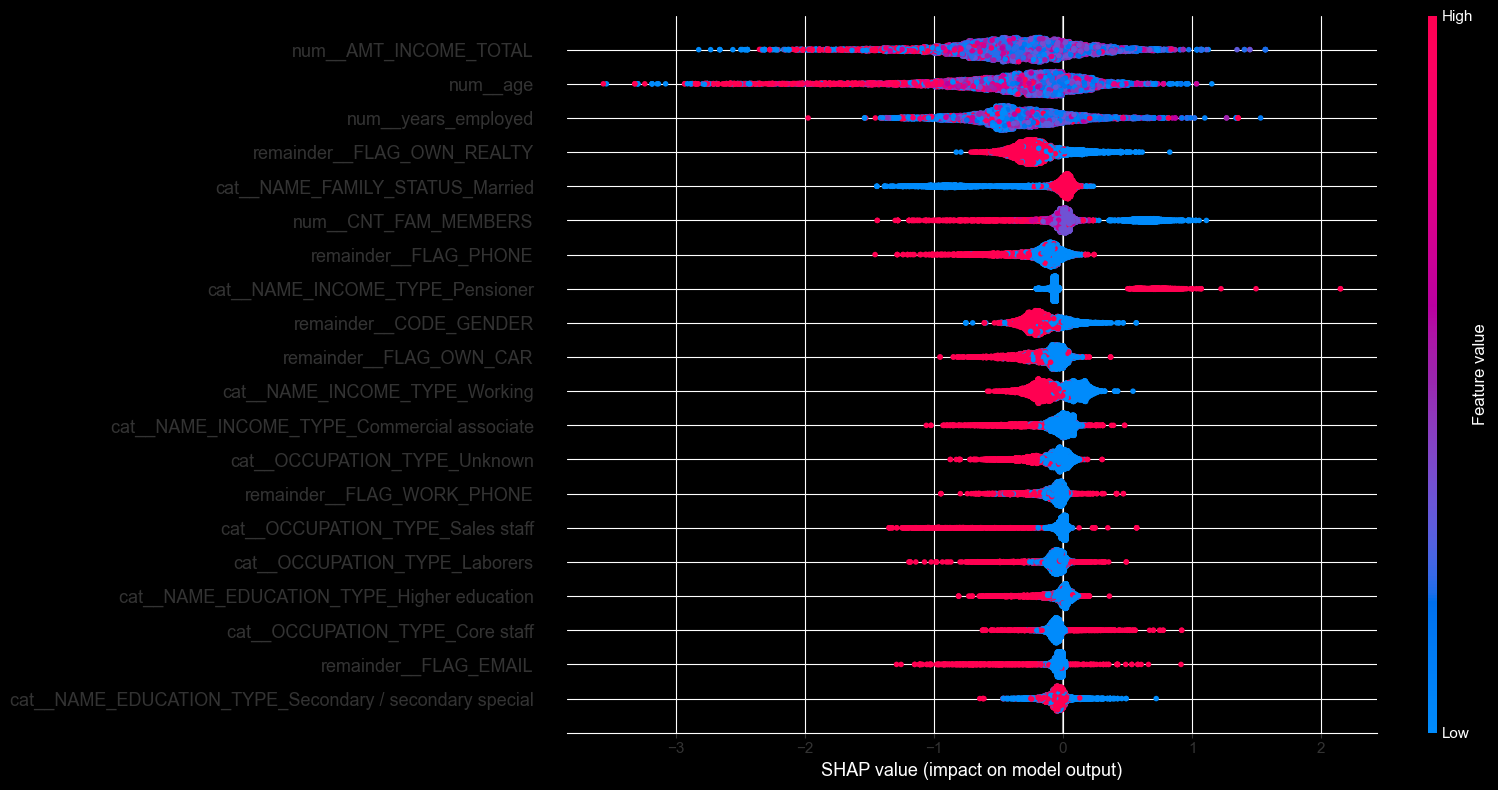

In [49]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_test_transformed_df, plot_size=(16, 8))


- Negative SHAP values reduce the chance that a client is labeled "bad"; positive SHAP values increase that probability.
